In [1]:
import numpy as np
import pandas as pd 
import random
from tqdm import tqdm
import scipy.sparse as sp
import sklearn.preprocessing as sk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer, normalize
import time
import sys
from matplotlib import pyplot as plt

In [2]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sp.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sp.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sp.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sp.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sp.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sp.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sp.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)



class Cosine_Similarity:


    def __init__(self, dataMatrix, topK=100, shrink = 0, normalize = True,
                 asymmetric_alpha = 0.5, tversky_alpha = 1.0, tversky_beta = 1.0,
                 similarity = "cosine", row_weights = None):
        """
        Computes the cosine similarity on the columns of dataMatrix
        If it is computed on URM=|users|x|items|, pass the URM as is.
        If it is computed on ICM=|items|x|features|, pass the ICM transposed.
        :param dataMatrix:
        :param topK:
        :param shrink:
        :param normalize:           If True divide the dot product by the product of the norms
        :param row_weights:         Multiply the values in each row by a specified value. Array
        :param asymmetric_alpha     Coefficient alpha for the asymmetric cosine
        :param similarity:  "cosine"        computes Cosine similarity
                            "adjusted"      computes Adjusted Cosine, removing the average of the users
                            "asymmetric"    computes Asymmetric Cosine
                            "pearson"       computes Pearson Correlation, removing the average of the items
                            "jaccard"       computes Jaccard similarity for binary interactions using Tanimoto
                            "dice"          computes Dice similarity for binary interactions
                            "tversky"       computes Tversky similarity for binary interactions
                            "tanimoto"      computes Tanimoto coefficient for binary interactions

        """
        """
        Asymmetric Cosine as described in: 
        Aiolli, F. (2013, October). Efficient top-n recommendation for very large scale binary rated datasets. In Proceedings of the 7th ACM conference on Recommender systems (pp. 273-280). ACM.
        
        """

        super(Cosine_Similarity, self).__init__()

        self.TopK = topK
        self.shrink = shrink
        self.normalize = normalize
        self.n_columns = dataMatrix.shape[1]
        self.n_rows = dataMatrix.shape[0]
        self.asymmetric_alpha = asymmetric_alpha
        self.tversky_alpha = tversky_alpha
        self.tversky_beta = tversky_beta

        self.dataMatrix = dataMatrix.copy()

        self.adjusted_cosine = False
        self.asymmetric_cosine = False
        self.pearson_correlation = False
        self.tanimoto_coefficient = False
        self.dice_coefficient = False
        self.tversky_coefficient = False

        if similarity == "adjusted":
            self.adjusted_cosine = True
        elif similarity == "asymmetric":
            self.asymmetric_cosine = True
        elif similarity == "pearson":
            self.pearson_correlation = True
        elif similarity == "jaccard" or similarity == "tanimoto":
            self.tanimoto_coefficient = True
            # Tanimoto has a specific kind of normalization
            self.normalize = False

        elif similarity == "dice":
            self.dice_coefficient = True
            self.normalize = False

        elif similarity == "tversky":
            self.tversky_coefficient = True
            self.normalize = False

        elif similarity == "cosine":
            pass
        else:
            raise ValueError("Cosine_Similarity: value for paramether 'mode' not recognized."
                             " Allowed values are: 'cosine', 'pearson', 'adjusted', 'asymmetric', 'jaccard', 'tanimoto',"
                             "dice, tversky."
                             " Passed value was '{}'".format(similarity))



        if self.TopK == 0:
            self.W_dense = np.zeros((self.n_columns, self.n_columns))


        self.use_row_weights = False

        if row_weights is not None:

            if dataMatrix.shape[0] != len(row_weights):
                raise ValueError("Cosine_Similarity: provided row_weights and dataMatrix have different number of rows."
                                 "Col_weights has {} columns, dataMatrix has {}.".format(len(row_weights), dataMatrix.shape[0]))

            self.use_row_weights = True
            self.row_weights = row_weights.copy()
            self.row_weights_diag = sps.diags(self.row_weights)

            self.dataMatrix_weighted = self.dataMatrix.T.dot(self.row_weights_diag).T






    def applyAdjustedCosine(self):
        """
        Remove from every data point the average for the corresponding row
        :return:
        """

        self.dataMatrix = check_matrix(self.dataMatrix, 'csr')


        interactionsPerRow = np.diff(self.dataMatrix.indptr)

        nonzeroRows = interactionsPerRow > 0
        sumPerRow = np.asarray(self.dataMatrix.sum(axis=1)).ravel()

        rowAverage = np.zeros_like(sumPerRow)
        rowAverage[nonzeroRows] = sumPerRow[nonzeroRows] / interactionsPerRow[nonzeroRows]


        # Split in blocks to avoid duplicating the whole data structure
        start_row = 0
        end_row= 0

        blockSize = 1000


        while end_row < self.n_rows:

            end_row = min(self.n_rows, end_row + blockSize)

            self.dataMatrix.data[self.dataMatrix.indptr[start_row]:self.dataMatrix.indptr[end_row]] -= \
                np.repeat(rowAverage[start_row:end_row], interactionsPerRow[start_row:end_row])

            start_row += blockSize




    def applyPearsonCorrelation(self):
        """
        Remove from every data point the average for the corresponding column
        :return:
        """

        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')


        interactionsPerCol = np.diff(self.dataMatrix.indptr)

        nonzeroCols = interactionsPerCol > 0
        sumPerCol = np.asarray(self.dataMatrix.sum(axis=0)).ravel()

        colAverage = np.zeros_like(sumPerCol)
        colAverage[nonzeroCols] = sumPerCol[nonzeroCols] / interactionsPerCol[nonzeroCols]


        # Split in blocks to avoid duplicating the whole data structure
        start_col = 0
        end_col= 0

        blockSize = 1000


        while end_col < self.n_columns:

            end_col = min(self.n_columns, end_col + blockSize)

            self.dataMatrix.data[self.dataMatrix.indptr[start_col]:self.dataMatrix.indptr[end_col]] -= \
                np.repeat(colAverage[start_col:end_col], interactionsPerCol[start_col:end_col])

            start_col += blockSize


    def useOnlyBooleanInteractions(self):

        # Split in blocks to avoid duplicating the whole data structure
        start_pos = 0
        end_pos= 0

        blockSize = 1000


        while end_pos < len(self.dataMatrix.data):

            end_pos = min(len(self.dataMatrix.data), end_pos + blockSize)

            self.dataMatrix.data[start_pos:end_pos] = np.ones(end_pos-start_pos)

            start_pos += blockSize




    def compute_similarity(self, start_col=None, end_col=None, block_size = 100):
        """
        Compute the similarity for the given dataset
        :param self:
        :param start_col: column to begin with
        :param end_col: column to stop before, end_col is excluded
        :return:
        """

        values = []
        rows = []
        cols = []

        start_time = time.time()
        start_time_print_batch = start_time
        processedItems = 0


        if self.adjusted_cosine:
            self.applyAdjustedCosine()

        elif self.pearson_correlation:
            self.applyPearsonCorrelation()

        elif self.tanimoto_coefficient or self.dice_coefficient or self.tversky_coefficient:
            self.useOnlyBooleanInteractions()


        # We explore the matrix column-wise
        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')


        # Compute sum of squared values to be used in normalization
        sumOfSquared = np.array(self.dataMatrix.power(2).sum(axis=0)).ravel()

        # Tanimoto does not require the square root to be applied
        if not (self.tanimoto_coefficient or self.dice_coefficient or self.tversky_coefficient):
            sumOfSquared = np.sqrt(sumOfSquared)

        if self.asymmetric_cosine:
            sumOfSquared_to_1_minus_alpha = np.power(sumOfSquared, 2 * (1 - self.asymmetric_alpha))
            sumOfSquared_to_alpha = np.power(sumOfSquared, 2 * self.asymmetric_alpha)


        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')

        start_col_local = 0
        end_col_local = self.n_columns

        if start_col is not None and start_col>0 and start_col<self.n_columns:
            start_col_local = start_col

        if end_col is not None and end_col>start_col_local and end_col<self.n_columns:
            end_col_local = end_col




        start_col_block = start_col_local

        this_block_size = 0

        # Compute all similarities for each item using vectorization
        while start_col_block < end_col_local:

            # Add previous block size
            processedItems += this_block_size

            end_col_block = min(start_col_block + block_size, end_col_local)
            this_block_size = end_col_block-start_col_block


            if time.time() - start_time_print_batch >= 30 or end_col_block==end_col_local:
                columnPerSec = processedItems / (time.time() - start_time)

                print("Similarity column {} ( {:2.0f} % ), {:.2f} column/sec, elapsed time {:.2f} min".format(
                    processedItems, processedItems / (end_col_local - start_col_local) * 100, columnPerSec, (time.time() - start_time)/ 60))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_print_batch = time.time()


            # All data points for a given item
            item_data = self.dataMatrix[:, start_col_block:end_col_block]
            item_data = item_data.toarray().squeeze()

            if self.use_row_weights:
                #item_data = np.multiply(item_data, self.row_weights)
                #item_data = item_data.T.dot(self.row_weights_diag).T
                this_block_weights = self.dataMatrix_weighted.T.dot(item_data)

            else:
                # Compute item similarities
                this_block_weights = self.dataMatrix.T.dot(item_data)



            for col_index_in_block in range(this_block_size):

                if this_block_size == 1:
                    this_column_weights = this_block_weights
                else:
                    this_column_weights = this_block_weights[:,col_index_in_block]


                columnIndex = col_index_in_block + start_col_block
                this_column_weights[columnIndex] = 0.0

                # Apply normalization and shrinkage, ensure denominator != 0
                if self.normalize:

                    if self.asymmetric_cosine:
                        denominator = sumOfSquared_to_alpha[columnIndex] * sumOfSquared_to_1_minus_alpha + self.shrink + 1e-6
                    else:
                        denominator = sumOfSquared[columnIndex] * sumOfSquared + self.shrink + 1e-6

                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)


                # Apply the specific denominator for Tanimoto
                elif self.tanimoto_coefficient:
                    denominator = sumOfSquared[columnIndex] + sumOfSquared - this_column_weights + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                elif self.dice_coefficient:
                    denominator = sumOfSquared[columnIndex] + sumOfSquared + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                elif self.tversky_coefficient:
                    denominator = this_column_weights + \
                                  (sumOfSquared[columnIndex] - this_column_weights)*self.tversky_alpha + \
                                  (sumOfSquared - this_column_weights)*self.tversky_beta + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                # If no normalization or tanimoto is selected, apply only shrink
                elif self.shrink != 0:
                    this_column_weights = this_column_weights/self.shrink


                #this_column_weights = this_column_weights.toarray().ravel()

                if self.TopK == 0:
                    self.W_dense[:, columnIndex] = this_column_weights

                else:
                    # Sort indices and select TopK
                    # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
                    # - Partition the data to extract the set of relevant items
                    # - Sort only the relevant items
                    # - Get the original item index
                    relevant_items_partition = (-this_column_weights).argpartition(self.TopK-1)[0:self.TopK]
                    relevant_items_partition_sorting = np.argsort(-this_column_weights[relevant_items_partition])
                    top_k_idx = relevant_items_partition[relevant_items_partition_sorting]

                    # Incrementally build sparse matrix, do not add zeros
                    notZerosMask = this_column_weights[top_k_idx] != 0.0
                    numNotZeros = np.sum(notZerosMask)

                    values.extend(this_column_weights[top_k_idx][notZerosMask])
                    rows.extend(top_k_idx[notZerosMask])
                    cols.extend(np.ones(numNotZeros) * columnIndex)





            start_col_block += block_size

        # End while on columns


        if self.TopK == 0:
            return self.W_dense

        else:

            W_sparse = sp.csr_matrix((values, (rows, cols)),
                                      shape=(self.n_columns, self.n_columns),
                                      dtype=np.float32)


            return W_sparse

In [3]:
class Utils(object):

    def __init__(self, train, tracks, target_playlists):
        self.train = train
        self.tracks = tracks
        self.target_playlists = target_playlists
        self.URM = self.build_URM()

    def get_target_playlists(self):
        return self.target_playlists

    @staticmethod
    def get_top_10(URM, target_playlist, row):
        my_songs = URM.indices[URM.indptr[target_playlist]:URM.indptr[target_playlist + 1]]
        row[my_songs] = -np.inf
        relevant_items_partition = (-row).argpartition(10)[0:10]
        relevant_items_partition_sorting = np.argsort(-row[relevant_items_partition])
        ranking = relevant_items_partition[relevant_items_partition_sorting]
        return ranking

    @staticmethod
    def get_similarity_normalized(matrix, normalize, knn, shrink, mode):
        if normalize is False:
            similarity = Cosine_Similarity(dataMatrix=matrix, normalize=False, similarity=mode, topK=knn)
        else:
            similarity = Cosine_Similarity(dataMatrix=matrix, normalize=True, shrink=shrink, similarity=mode, topK=knn)
        S = similarity.compute_similarity()
        return S.tocsr()

    @staticmethod
    def get_UCM(URM):
        UCM = TfidfTransformer().fit_transform(URM.T).T
        return UCM

    def build_URM(self):
        grouped = self.train.groupby('playlist_id', as_index=True).apply((lambda playlist: list(playlist['track_id'])))
        URM = MultiLabelBinarizer(classes=self.tracks['track_id'].unique(), sparse_output=True).fit_transform(grouped)
        return URM.tocsr()

    def get_URM(self):
        return self.URM

    def get_ICM(self):  # returns Item Content Matrix
        grouped = self.tracks.groupby('track_id', as_index=True).apply((lambda track: list(track['artist_id'])))

        ICM_artists = MultiLabelBinarizer(classes=self.tracks['artist_id'].unique(), sparse_output=True).fit_transform(
            grouped)
        ICM_artists = ICM_artists * 0.8  # best weight for the artis feature
        ICM_artists = TfidfTransformer().fit_transform(ICM_artists.T).T

        grouped = self.tracks.groupby('track_id', as_index=True).apply((lambda track: list(track['album_id'])))
        ICM_albums = MultiLabelBinarizer(classes=self.tracks['album_id'].unique(), sparse_output=True).fit_transform(
            grouped)
        ICM_albums = TfidfTransformer().fit_transform(ICM_albums.T).T

        ICM = sp.hstack((ICM_artists, ICM_albums))
        return ICM

    def get_itemsim_CB(self, knn, shrink, mode, normalize):
        ICM = self.get_ICM()
        return self.get_similarity_normalized(ICM.T, normalize, knn, shrink, mode)

    def get_itemsim_CF(self, URM, knn, shrink, mode, normalize):
        return self.get_similarity_normalized(URM, normalize, knn, shrink, mode)

    def get_usersim_CF(self, URM, knn, shrink, mode, normalize):
        return self.get_similarity_normalized(URM.T, normalize, knn, shrink, mode)

In [4]:
class Eval(object):

    def __init__(self, u):
        self.URM = u.get_URM()
        self.target_playlists = None
        self.target_tracks = None
        self.URM_train = None
        self.build_URM_test2()

    def build_URM_test(self):
        total_users = self.URM.shape[0]
        self.URM_train = self.URM.copy().tolil()
        possibile_playlists = [i for i in range(total_users) if len(
            self.URM.indices[self.URM.indptr[i]:self.URM.indptr[i + 1]]) > 10]  # playlists with more than 10 songs

        self.target_playlists = pd.DataFrame(data=random.sample(possibile_playlists, int(0.20 * total_users)),
                                             columns=['playlist_id'])  # target playlists, 20% of total playlists
        self.target_tracks = []

        for idx in list(self.target_playlists['playlist_id']):
            target_songs = random.sample(list(self.URM.indices[self.URM.indptr[idx]:self.URM.indptr[idx + 1]]), 10)
            self.URM_train[idx, target_songs] = 0
            self.target_tracks.append(target_songs)

        self.target_tracks = np.array(self.target_tracks)
        self.URM_train = self.URM_train.tocsr()

    def build_URM_test2(self):
        possible_playlists = [i for i in range(self.URM.shape[0]) if len(
            self.URM.indices[self.URM.indptr[i]:self.URM.indptr[i + 1]]) > 10]  # playlists with more than 10 songs
        self.target_playlists = np.random.choice(possible_playlists, 10000, replace=False)
        self.URM_train = self.URM.copy().tolil()
        self.target_tracks = []

        for idx in self.target_playlists[:5000]:
            length = int(len(self.URM[idx].indices) * 0.2)
            target_songs = self.URM[idx].indices[-length:]
            self.URM_train[idx, target_songs] = 0
            self.target_tracks.append(target_songs)

        for idx in self.target_playlists[-5000:]:
            length = int(len(self.URM[idx].indices) * 0.2)
            target_songs = np.random.choice(self.URM[idx].indices, length, replace=False)
            self.URM_train[idx, target_songs] = 0
            self.target_tracks.append(target_songs)

        self.target_tracks = np.array(self.target_tracks)
        self.target_playlists = pd.DataFrame(self.target_playlists, columns=['playlist_id'])  # target playlists, 20% of total playlists
        self.URM_train = self.URM_train.tocsr()

    def get_URM_train(self):
        return self.URM_train

    def get_target_playlists(self):
        return self.target_playlists

    def get_target_tracks(self):
        return self.target_tracks

    @staticmethod
    def AP(recommended_items, relevant_items):
        relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
        p_at_k = relevant * np.cumsum(relevant, dtype=np.float32) / (1 + np.arange(relevant.shape[0]))
        map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], relevant.shape[0]])
        return map_score

    # input has to be the URM and the dataframe returned by the recommender
    # NB: the songs in the dataframe must be a list (or ndarray), not a string!
    def MAP(self, df, relevant_items):
        print("Evaluating", flush=True)
        MAP = 0.0
        num_eval = 0

        for i in range(df.shape[0]):
            relevant = relevant_items[i]
            if len(relevant_items) > 0:
                recommended_items = df['track_ids'][i]
                num_eval += 1
                MAP += self.AP(recommended_items, relevant)

        MAP /= num_eval
        print("Recommender performance is {:.8f}".format(MAP))
        return MAP

    @staticmethod
    def result_diff(result_dfs):

        # load  all results form various recommenders
        # for file in files:
        #   results.append(pd.read_csv(file))

        for i, result in enumerate(result_dfs):
            for j, result_2 in enumerate(result_dfs):
                tot_diff = 0
                for row, row_2 in zip(result['track_ids'], result_2['track_ids']):
                    row, row_2 = list(row), list(row_2)
                    row = [el for el in row if el != ' ']
                    row_2 = [el for el in row_2 if el != ' ']
                    tot_diff += [1 for x, y in zip(row, row_2) if x != y].count(1)
                print('Total differences between res %d and res %d are: %d' % (i, j, tot_diff))

In [5]:
class SlimBPR_utils(object):

    def __init__(self,
                 URM,
                 learning_rate=0.01,
                 epochs=1,
                 positive_item_regularization=1.0,
                 negative_item_regularization=1.0,
                 nnz=1):
        self.URM = URM
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.positive_item_regularization = positive_item_regularization
        self.negative_item_regularization = negative_item_regularization
        self.nnz = nnz
        self.n_playlist = self.URM.shape[0]
        self.n_track = self.URM.shape[1]

        self.similarity_matrix = sp.lil_matrix((self.n_track, self.n_track))

    def sample(self):

        playlist_id = np.random.choice(self.n_playlist)

        # get tracks in playlist and choose one
        tracks = self.URM[playlist_id, :].indices
        pos_track_id = np.random.choice(tracks)

        negTrackSelected = False

        while not negTrackSelected:
            neg_track_id = np.random.choice(self.n_track)
            if neg_track_id not in tracks:
                negTrackSelected = True
        return playlist_id, pos_track_id, neg_track_id

    def epochIteration(self):

        numPosInteractions = int(self.URM.nnz * self.nnz)

        # sampling without replacement
        # tqdm performs range op with progress visualization
        for num_sample in tqdm(range(numPosInteractions)):

            playlist_id, pos_track_id, neg_track_id = self.sample()

            tracks = self.URM[playlist_id, :].indices

            # Prediction
            x_i = self.similarity_matrix[pos_track_id, tracks].sum()
            x_j = self.similarity_matrix[neg_track_id, tracks].sum()

            # Gradient
            x_ij = x_i - x_j

            gradient = 1 / (1 + np.exp(x_ij))

            for i in tracks:
                # dp and dn outside for?
                dp = gradient - self.positive_item_regularization * x_i
                self.similarity_matrix[pos_track_id, i] = self.similarity_matrix[
                                                              pos_track_id, i] + self.learning_rate * dp
                dn = gradient - self.negative_item_regularization * x_j
                self.similarity_matrix[neg_track_id, i] = self.similarity_matrix[
                                                              neg_track_id, i] - self.learning_rate * dn

            self.similarity_matrix[pos_track_id, pos_track_id] = 0
            self.similarity_matrix[pos_track_id, pos_track_id] = 0

    def get_S_SLIM_BPR(self, knn):
        print('get S Slim BPR...')

        for numEpoch in range(self.epochs):
            print('Epoch: ', numEpoch)
            self.epochIteration()

        # replace with our own knn methods
        print('Keeping only knn =', knn, '...')
        similarity_matrix_csr = self.similarity_matrix.tocsr()

        for row in tqdm(range(0, similarity_matrix_csr.shape[0])):
            ordered_indices = similarity_matrix_csr[row, :].data.argsort()[:-knn]
            similarity_matrix_csr[row, :].data[ordered_indices] = 0
        sp.csr_matrix.eliminate_zeros(similarity_matrix_csr)

        return similarity_matrix_csr

In [6]:
class Item_CBR(object):

    def __init__(self, u):
        self.u = u
        self.URM = None
        self.S = None

    def fit(self, URM, knn, shrink, mode, normalize):
        self.URM = URM
        self.S = self.u.get_itemsim_CB(knn, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row = self.URM[target_playlist].dot(self.S).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [7]:
class Item_CFR(object):

    def __init__(self, u):
        self.u = u
        self.URM = None
        self.S = None

    def fit(self, URM, knn, shrink, mode, normalize):
        self.URM = URM
        self.S = self.u.get_itemsim_CF(self.URM, knn, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row = self.URM[target_playlist].dot(self.S).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [8]:
class User_CFR(object):

    def __init__(self, u):
        self.u = u
        self.URM = None
        self.S = None

    def fit(self, URM, knn, shrink, mode, normalize):
        self.URM = URM
        self.S = self.u.get_usersim_CF(self.URM, knn, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row = self.S[target_playlist].dot(self.URM).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [9]:
class Ensemble_item(object):

    def __init__(self, u):
        self.u = u
        self.S_CB = None
        self.S_CF = None
        self.URM = None
        self.alfa = None

    def fit(self, URM, knn1, knn2, shrink, mode, normalize, alfa):
        self.URM = URM
        self.alfa = alfa
        self.S_CF = self.u.get_itemsim_CF(self.URM, knn1, shrink, mode, normalize)
        self.S_CB = self.u.get_itemsim_CB(knn2, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row_cb = self.URM[target_playlist].dot(self.S_CB)
        row_cf = self.URM[target_playlist].dot(self.S_CF)
        row = ((self.alfa*row_cb) + ((1-self.alfa)*row_cf)).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [10]:
class Ensemble_cf(object):

    def __init__(self, u):
        self.u = u
        self.S_CF_I = None
        self.S_CF_U = None
        self.URM = None
        self.alfa = None

    def fit(self, URM, knn1, knn2, shrink, mode, normalize, alfa):
        self.URM = URM
        self.alfa = alfa
        self.S_CF_I = self.u.get_itemsim_CF(self.URM, knn1, shrink, mode, normalize)
        self.S_CF_U = self.u.get_usersim_CF(self.URM, knn2, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row_cf_i = self.URM[target_playlist].dot(self.S_CF_I)
        row_cf_u = self.S_CF_U[target_playlist].dot(self.URM)
        row = ((self.alfa * row_cf_i) + ((1-self.alfa) * row_cf_u)).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [11]:
class Hybrid(object):

    def __init__(self, u):
        self.u = u
        self.S_CB = None
        self.S_CF_item = None
        self.S_CF_user = None
        self.S_user = None
        self.S_item = None
        self.URM = None
        self.weights = None

    def fit(self, URM, knn1, knn2, knn3, shrink, mode, normalize, weights):
        self.URM = URM
        self.weights = weights
        self.S_CF_item = self.u.get_itemsim_CF(self.URM, knn1, shrink, mode, normalize)
        self.S_user = self.u.get_usersim_CF(self.URM, knn2, shrink, mode, normalize)
        self.S_CB = self.u.get_itemsim_CB(knn3, shrink, mode, normalize)
        self.S_item = (weights[0] * self.S_CF_item) + ((1 - weights[0]) * self.S_CB)

    def recommend(self, target_playlist):
        row_user = self.S_user[target_playlist].dot(self.URM)
        row_item = self.URM[target_playlist].dot(self.S_item)
        row = ((self.weights[1] * row_item) + ((1 - self.weights[1]) * row_user)).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [12]:
class Ensemble_cfcb(object):

    def __init__(self, u):
        self.u = u
        self.S_CB = None
        self.S_CF_I = None
        self.S_CF_U = None
        self.URM = None
        self.weights = None

    def fit(self, URM, knn1, knn2, knn3, shrink, mode, normalize, weights):
        self.URM = URM
        self.weights = weights
        self.S_CF_I = self.u.get_itemsim_CF(self.URM, knn1, shrink, mode, normalize)
        self.S_CF_U = self.u.get_usersim_CF(self.URM, knn2, shrink, mode, normalize)
        self.S_CB = self.u.get_itemsim_CB(knn3, shrink, mode, normalize)

    def recommend(self, target_playlist):
        row_cb = self.URM[target_playlist].dot(self.S_CB)
        row_cf_i = self.URM[target_playlist].dot(self.S_CF_I)
        row_cf_u = self.S_CF_U[target_playlist].dot(self.URM)
        row = ((self.weights[0] * row_cf_i) + (self.weights[1] * row_cf_u) + (
                    self.weights[2] * row_cb)).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [13]:
class Slim_BPR(object):

    def __init__(self):
        self.URM = None
        self.num_playlist_to_recommend = None
        self.S = None
        self.u = None

    def fit(self, URM, num_playlist_to_recommend,
            learning_rate, epochs, positive_item_regularization,
            negative_item_regularization, nzz, u, knn):
        self.URM = URM
        self.num_playlist_to_recommend = num_playlist_to_recommend
        self.u = u
        BPR_gen = SlimBPR_utils(self.URM)
        self.S = BPR_gen.get_S_SLIM_BPR(knn)

    def recommend(self, target_playlist):
        row = (self.URM[target_playlist].dot(self.S)).toarray().ravel()
        return self.u.get_top_10(self.URM, target_playlist, row)

In [14]:
class Ensemble_cfcb_sbpr(object):

    def __init__(self, u):
        self.u = u
        self.S_CB = None
        self.S_CF_I = None
        self.S_CF_U = None
        self.S = None
        self.URM = None
        self.weights = None

    def fit(self, URM, knn1, knn2, knn3, knn4, shrink, mode, normalize, weights):
        self.URM = URM
        self.weights = weights
        BPR_gen = SlimBPR_utils(self.URM)
        self.S = BPR_gen.get_S_SLIM_BPR(knn4)
        self.S_CF_I = self.u.get_itemsim_CF(self.URM, knn1, shrink, mode, normalize)
        self.S_CF_U = self.u.get_usersim_CF(self.URM, knn2, shrink, mode, normalize)
        self.S_CB = self.u.get_itemsim_CB(knn3, shrink, mode, normalize)

    def recommend(self, target_playlist):
            row_R_CB = self.URM[target_playlist].dot(self.S_CB)
            row_R_CF_I = self.URM[target_playlist].dot(self.S_CF_I)
            row_R_CF_U = self.S_CF_U[target_playlist].dot(self.URM)
            row_R_Slim_BPR = self.URM[target_playlist].dot(self.S)
            row = (self.weights[0] * row_R_CF_I) + (self.weights[1] * row_R_CF_U) + (self.weights[2] * row_R_CB) + (
                        self.weights[3] * row_R_Slim_BPR).toarray().ravel()

            return self.u.get_top_10(self.URM, target_playlist, row)

In [16]:
class Recommender(object):

    def __init__(self, n=5):
        self.train = pd.read_csv("../data/train.csv")
        self.tracks = pd.read_csv("../data/tracks.csv")
        self.target_playlists = pd.read_csv("../data/target_playlists.csv")
        self.u = Utils(self.train, self.tracks, self.target_playlists)
        self.e = Eval(self.u)
        self.URM_full = self.preprocess_URM(self.u.get_URM(), self.target_playlists, n)
        self.URM_train = self.preprocess_URM(self.e.get_URM_train(), self.e.get_target_playlists(), n)

    @staticmethod
    def evaluate(recommender, is_test, target_playlists):
        final_result = pd.DataFrame(index=range(target_playlists.shape[0]), columns=('playlist_id', 'track_ids'))

        for i, target_playlist in tqdm(enumerate(np.array(target_playlists))):
            result_tracks = recommender.recommend(int(target_playlist))
            string_rec = ' '.join(map(str, result_tracks.reshape(1, 10)[0]))
            final_result['playlist_id'][i] = int(target_playlist)
            if is_test:
                final_result['track_ids'][i] = result_tracks
            else:
                final_result['track_ids'][i] = string_rec
        return final_result

    @staticmethod
    def preprocess_URM(URM, target_playlists, n):
        URM_new = URM.copy().tolil()
        total_users = URM.shape[0]
        possible_playlists = [i for i in range(total_users) if len(
            URM.indices[URM.indptr[i]:URM.indptr[i + 1]]) <= n]
        discard = np.setdiff1d(np.array(possible_playlists), target_playlists['playlist_id'])
        URM_new[discard, :] = 0
        return URM_new.tocsr()

    def rec_and_evaluate(self, rec, target_playlists):
        result = self.evaluate(rec, True, target_playlists)
        return self.e.MAP(result, self.e.get_target_tracks())

    def rec_and_save(self, rec, target_playlists, path):
        result = self.evaluate(rec, False, target_playlists)
        result.to_csv(path, index=False)

    def recommend_itemCBR(self, is_test, knn=250, shrink=10, mode='cosine', normalize=True):
        rec = Item_CBR(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn, shrink, mode, normalize)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn, shrink, mode, normalize)
            self.rec_and_save(rec, target_playlists, "predictions/item_cbr.csv")

    def recommend_itemCFR(self, is_test, knn=250, shrink=10, mode='cosine', normalize=True):
        rec = Item_CFR(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn, shrink, mode, normalize)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn, shrink, mode, normalize)
            self.rec_and_save(rec, target_playlists, "predictions/item_cfr.csv")

    def recommend_userCFR(self, is_test, knn=250, shrink=10, mode='cosine', normalize=True):
        rec = User_CFR(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn, shrink, mode, normalize)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn, shrink, mode, normalize)
            self.rec_and_save(rec, target_playlists, "predictions/user_cfr1.csv")

    def recommend_slimBPR(self, is_test, knn=100):
        rec = Slim_BPR()
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, 10000,
                    learning_rate=0.1, epochs=1, positive_item_regularization=1.0,
                    negative_item_regularization=1.0, nzz=1, u=self.u, knn=knn)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, 10000,
                    learning_rate=0.1, epochs=1, positive_item_regularization=1.0,
                    negative_item_regularization=1.0, nzz=1, u=self.u, knn=knn)
            self.rec_and_save(rec, target_playlists, "predictions/slimBPR.csv")

    def recommend_ensemble_item(self, is_test, alfa=0.6, knn1=250, knn2=150, shrink=10, mode='cosine', normalize=True):
        rec = Ensemble_item(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, shrink, mode, normalize, alfa)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn1, knn2, shrink, mode, normalize, alfa)
            self.rec_and_save(rec, target_playlists, "predictions/ensemble_item.csv")

    def recommend_ensemble_cf(self, is_test, alfa=0.6, knn1=250, knn2=250, shrink=10, mode='cosine', normalize=True):
        rec = Ensemble_cf(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, shrink, mode, normalize, alfa)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn1, knn2, shrink, mode, normalize, alfa)
            self.rec_and_save(rec, target_playlists, "predictions/ensemble_cf.csv")

    def recommend_ensemble_cfcb(self, is_test, weights=(0.6, 0.4, 0.5), knn1=250, knn2=250, knn3=150, shrink=10,
                                mode='cosine', normalize=True):
        rec = Ensemble_cfcb(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, knn3, shrink, mode, normalize, weights)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn1, knn2, knn3, shrink, mode, normalize, weights)
            self.rec_and_save(rec, target_playlists, "predictions/ensemble_cfcb.csv")

    def recommend_hybrid(self, is_test, weights=(0.6, 0.7), knn1=250, knn2=250, knn3=150, shrink=10, mode='cosine',
                         normalize=True):
        rec = Hybrid(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, knn3, shrink, mode, normalize, weights)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.u.get_target_playlists()
            rec.fit(self.URM_full, knn1, knn2, knn3, shrink, mode, normalize, weights)
            self.rec_and_save(rec, target_playlists, "predictions/hybrid.csv")

    def recommend_ensemble_cfcb_SlimBPR(self, is_test, weights=(0.6, 0.5, 0.5, 0.6), knn1=250, knn2=250, knn3=150,
                                        knn4=800, shrink=10, mode='cosine', normalize=False):
        rec = Ensemble_cfcb_sbpr(self.u)
        if is_test:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, knn3, knn4, shrink, mode, normalize, weights)
            return self.rec_and_evaluate(rec, target_playlists)
        else:
            target_playlists = self.e.get_target_playlists()
            rec.fit(self.URM_train, knn1, knn2, knn3, knn4, shrink, mode, normalize, weights)
            self.rec_and_save(rec, target_playlists, "predictions/ensemble_cfcb_bpr.csv")

In [17]:
run = Recommender()

In [ ]:
run.recommend_ensemble_item(True, 0.8)

In [ ]:
URM = run.e.URM_train
URM_new = URM.copy().tolil()
target_playlists = run.e.get_target_playlists()

In [ ]:
URM_new.nnz

In [ ]:
total_users = URM.shape[0]
possible_playlists = [i for i in range(total_users) if len(
    URM.indices[URM.indptr[i]:URM.indptr[i + 1]]) <= 5]
discard = np.setdiff1d(np.array(possible_playlists), target_playlists['playlist_id'])
URM_new[discard,:] = 0

In [ ]:
URM_new.nnz

In [ ]:
URM_new

In [19]:
URM = run.e.get_URM_train()
BPR_gen = SlimBPR_utils(URM)
S = BPR_gen.get_S_SLIM_BPR(500)


  0%|          | 72/1158302 [00:00<27:00, 714.86it/s]


get S Slim BPR...
Epoch:  0


  1%|          | 12544/1158302 [00:14<22:01, 866.94it/s]


  2%|▏         | 24987/1158302 [00:28<20:42, 912.15it/s]


  3%|▎         | 37461/1158302 [00:42<20:09, 926.95it/s]


  4%|▍         | 49998/1158302 [00:56<20:44, 890.55it/s]


  5%|▌         | 62545/1158302 [01:10<20:13, 903.18it/s]


  6%|▋         | 74982/1158302 [01:24<19:51, 909.29it/s]


  8%|▊         | 87387/1158302 [01:38<22:17, 800.69it/s]


  9%|▊         | 99869/1158302 [01:51<19:41, 895.90it/s]


 10%|▉         | 112127/1158302 [02:05<19:18, 902.92it/s]


 11%|█         | 124335/1158302 [02:19<19:04, 903.37it/s]


 12%|█▏        | 136624/1158302 [02:33<19:37, 867.54it/s]


 13%|█▎        | 148831/1158302 [02:46<18:48, 894.25it/s]


 14%|█▍        | 160990/1158302 [03:00<18:32, 896.65it/s]


 15%|█▍        | 173100/1158302 [03:14<18:37, 881.65it/s]


 16%|█▌        | 185289/1158302 [03:27<18:16, 887.14it/s]


 17%|█▋        | 197261/1158302 [03:41<21:14, 754.15it/s]


 18%|█▊        | 209251/1158302 [03:55<18:35, 851.13it/s]


 19%|█▉        | 221229/1158302 [04:09<18:17, 854.15it/s]


 20%|██        | 233096/1158302 [04:23<17:30, 881.08it/s]


 21%|██        | 244684/1158302 [04:36<17:55, 849.23it/s]


 22%|██▏       | 255043/1158302 [04:51<20:50, 722.47it/s]


 23%|██▎       | 266120/1158302 [05:05<18:59, 783.07it/s]


 24%|██▍       | 277258/1158302 [05:19<17:11, 854.24it/s]


 25%|██▍       | 288651/1158302 [05:32<17:21, 835.30it/s]


 26%|██▌       | 300042/1158302 [05:46<16:56, 844.18it/s]


 27%|██▋       | 311636/1158302 [06:00<16:49, 838.46it/s]


 28%|██▊       | 323024/1158302 [06:14<16:56, 821.87it/s]


 29%|██▉       | 334537/1158302 [06:28<16:07, 851.21it/s]


 30%|██▉       | 345627/1158302 [06:42<16:23, 826.00it/s]


 31%|███       | 356649/1158302 [06:56<16:24, 814.51it/s]


 32%|███▏      | 367911/1158302 [07:10<15:36, 843.92it/s]


 33%|███▎      | 379327/1158302 [07:23<15:16, 850.02it/s]


 34%|███▍      | 391295/1158302 [07:37<14:40, 870.62it/s]


 35%|███▍      | 402810/1158302 [07:51<14:41, 857.39it/s]


 36%|███▌      | 414387/1158302 [08:05<14:32, 852.23it/s]


 37%|███▋      | 426364/1158302 [08:18<13:52, 879.37it/s]


 38%|███▊      | 438476/1158302 [08:32<14:08, 848.78it/s]


 39%|███▉      | 450525/1158302 [08:46<13:02, 904.36it/s]


 40%|███▉      | 462624/1158302 [09:00<13:19, 870.08it/s]


 41%|████      | 474493/1158302 [09:13<13:54, 819.49it/s]


 42%|████▏     | 486419/1158302 [09:27<12:41, 882.43it/s]


 43%|████▎     | 498302/1158302 [09:41<12:28, 881.50it/s]


 44%|████▍     | 510328/1158302 [09:54<12:18, 877.47it/s]


 45%|████▌     | 522358/1158302 [10:08<12:16, 863.32it/s]


 46%|████▌     | 534330/1158302 [10:22<11:51, 876.44it/s]


 47%|████▋     | 546296/1158302 [10:35<11:37, 876.80it/s]


 48%|████▊     | 558302/1158302 [10:49<11:33, 864.93it/s]


 49%|████▉     | 570277/1158302 [11:03<11:17, 868.37it/s]


 50%|█████     | 582220/1158302 [11:17<11:08, 861.68it/s]


 51%|█████▏    | 594147/1158302 [11:30<10:40, 880.91it/s]


 52%|█████▏    | 606074/1158302 [11:44<10:33, 871.70it/s]


 53%|█████▎    | 618044/1158302 [11:58<10:03, 895.29it/s]


 54%|█████▍    | 629977/1158302 [12:11<10:01, 878.03it/s]


 55%|█████▌    | 641920/1158302 [12:25<09:47, 878.42it/s]


 56%|█████▋    | 653850/1158302 [12:39<09:50, 853.96it/s]


 57%|█████▋    | 665796/1158302 [12:52<09:37, 853.46it/s]


 59%|█████▊    | 677668/1158302 [13:06<09:10, 873.03it/s]


 60%|█████▉    | 689484/1158302 [13:20<09:05, 859.52it/s]


 61%|██████    | 701293/1158302 [13:34<08:57, 850.17it/s]


 62%|██████▏   | 713196/1158302 [13:47<08:30, 871.14it/s]


 63%|██████▎   | 725090/1158302 [14:01<08:33, 843.40it/s]


 64%|██████▎   | 736927/1158302 [14:15<07:59, 878.72it/s]


 65%|██████▍   | 748745/1158302 [14:28<08:25, 810.17it/s]


 66%|██████▌   | 760211/1158302 [14:42<07:58, 831.17it/s]


 67%|██████▋   | 771801/1158302 [14:56<07:35, 847.78it/s]


 68%|██████▊   | 783396/1158302 [15:10<07:37, 819.55it/s]


 69%|██████▊   | 794819/1158302 [15:24<07:14, 836.67it/s]


 70%|██████▉   | 806278/1158302 [15:37<07:01, 834.39it/s]


 71%|███████   | 817820/1158302 [15:51<06:48, 832.58it/s]


 72%|███████▏  | 829351/1158302 [16:05<06:41, 818.44it/s]


 73%|███████▎  | 840845/1158302 [16:18<06:29, 814.00it/s]


 74%|███████▎  | 852290/1158302 [16:32<06:19, 807.20it/s]


 75%|███████▍  | 863671/1158302 [16:46<05:54, 830.74it/s]


 76%|███████▌  | 875042/1158302 [17:00<05:36, 841.36it/s]


 77%|███████▋  | 886467/1158302 [17:13<05:22, 842.63it/s]


 78%|███████▊  | 897969/1158302 [17:27<05:11, 835.19it/s]


 79%|███████▊  | 909485/1158302 [17:41<04:57, 837.56it/s]


 79%|███████▉  | 920833/1158302 [17:55<04:49, 819.11it/s]


 80%|████████  | 932349/1158302 [18:08<04:30, 836.36it/s]


 81%|████████▏ | 943757/1158302 [18:22<04:10, 856.76it/s]


 82%|████████▏ | 955093/1158302 [18:36<04:07, 822.57it/s]


 83%|████████▎ | 966523/1158302 [18:50<03:51, 827.12it/s]


 84%|████████▍ | 977898/1158302 [19:03<03:45, 801.20it/s]


 85%|████████▌ | 989343/1158302 [19:17<03:21, 836.69it/s]


 86%|████████▋ | 1000683/1158302 [19:31<03:13, 813.89it/s]


 87%|████████▋ | 1011721/1158302 [19:45<03:00, 812.69it/s]


 88%|████████▊ | 1022841/1158302 [19:58<02:53, 781.32it/s]


 89%|████████▉ | 1034023/1158302 [20:12<02:26, 848.19it/s]


 90%|█████████ | 1044995/1158302 [20:25<02:17, 822.62it/s]


 91%|█████████ | 1056097/1158302 [20:39<02:05, 816.17it/s]


 92%|█████████▏| 1067247/1158302 [20:52<01:51, 817.95it/s]


 93%|█████████▎| 1078478/1158302 [21:06<01:36, 823.55it/s]


 94%|█████████▍| 1089673/1158302 [21:19<01:24, 811.46it/s]


 95%|█████████▌| 1100494/1158302 [21:33<01:10, 816.03it/s]


 96%|█████████▌| 1111323/1158302 [21:46<00:56, 824.94it/s]


 97%|█████████▋| 1121122/1158302 [22:00<00:48, 766.64it/s]


 98%|█████████▊| 1131407/1158302 [22:14<00:35, 763.35it/s]


 99%|█████████▊| 1142436/1158302 [22:28<00:19, 806.23it/s]


100%|█████████▉| 1153572/1158302 [22:41<00:05, 824.66it/s]


100%|██████████| 1158302/1158302 [22:47<00:00, 847.11it/s]

Keeping only knn = 500 ...



100%|██████████| 20635/20635 [00:04<00:00, 4316.61it/s]

Similarity column 20600 ( 100 % ), 704.10 column/sec, elapsed time 0.49 min
Similarity column 25400 ( 50 % ), 846.54 column/sec, elapsed time 0.50 min
Similarity column 50400 ( 100 % ), 840.35 column/sec, elapsed time 1.00 min
Similarity column 20600 ( 100 % ), 4089.66 column/sec, elapsed time 0.08 min


In [41]:
S_CF_I = run.u.get_itemsim_CF(URM, 250, 10, 'cosine', True)
S_CF_U = run.u.get_usersim_CF(URM, 250, 10, 'cosine', True)
S_CB = run.u.get_itemsim_CB(150, 10, 'cosine', True)

Similarity column 20600 ( 100 % ), 747.70 column/sec, elapsed time 0.46 min
Similarity column 21800 ( 43 % ), 726.53 column/sec, elapsed time 0.50 min
Similarity column 42700 ( 85 % ), 710.93 column/sec, elapsed time 1.00 min
Similarity column 50400 ( 100 % ), 705.13 column/sec, elapsed time 1.19 min
Similarity column 20600 ( 100 % ), 3277.08 column/sec, elapsed time 0.10 min


In [42]:
R_CB = URM.dot(S_CB)
R_CF_I = URM.dot(S_CF_I)
R_CF_U = S_CF_U.dot(URM)
R_Slim_BPR = URM.dot(S)

([<matplotlib.axis.XTick at 0x1a2bfdfb00>,
 <a list of 11 Text xticklabel objects>)

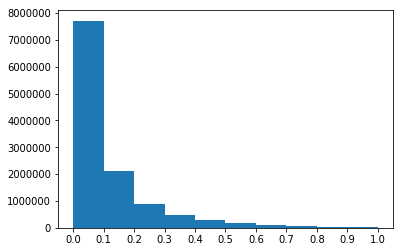

In [67]:
plt.hist(10*R_CB.data, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

([<matplotlib.axis.XTick at 0x1a2ef982e8>,
 <a list of 11 Text xticklabel objects>)

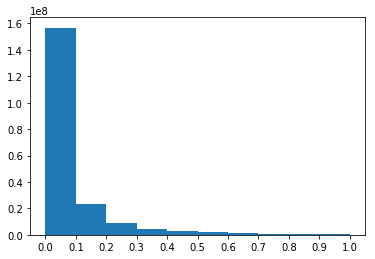

In [62]:
plt.hist(R_CF_I.data, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

([<matplotlib.axis.XTick at 0x1a2d2bef28>,
 <a list of 11 Text xticklabel objects>)

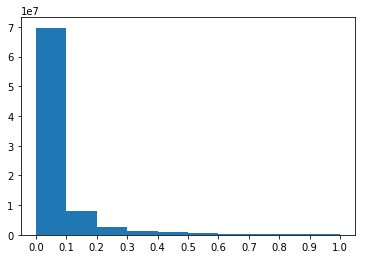

In [65]:
plt.hist(0.3*R_CF_U.data, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

(array([3.62300000e+03, 5.06519784e+08, 8.71372800e+06, 2.58397000e+05,
        2.52090000e+04, 3.31300000e+03, 4.44000000e+02, 1.03000000e+02,
        2.20000000e+01, 7.00000000e+00]),
 array([-0.79986279, -0.33524138,  0.12938004,  0.59400145,  1.05862286,
         1.52324428,  1.98786569,  2.45248711,  2.91710852,  3.38172993,
         3.84635135]),
 <a list of 10 Patch objects>)

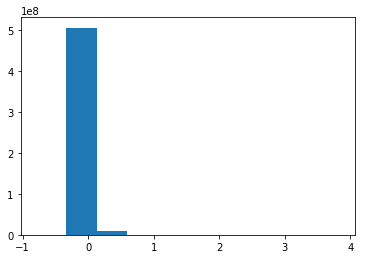

In [48]:
plt.hist(R_Slim_BPR.data)

In [68]:
weights = [10, 1, 0.3, 0]
is_test = True

In [69]:
target_playlists = run.e.get_target_playlists()

In [70]:
final_result = pd.DataFrame(index=range(target_playlists.shape[0]), columns=('playlist_id', 'track_ids'))

for i, target_playlist in tqdm(enumerate(np.array(target_playlists))):
    target_playlist = int(target_playlist)
    row_R_CB = URM[target_playlist].dot(S_CB)
    row_R_CF_I = URM[target_playlist].dot(S_CF_I)
    row_R_CF_U = S_CF_U[target_playlist].dot(URM)
    row_R_Slim_BPR = URM[target_playlist].dot(S)
    #print(row_R_CB.data.max())
    #print('***********************')
    #print(row_R_CF_I.data.max())
    #print('***********************')
    #print(row_R_CF_U.data.max())
    #print('***********************')
    #print(row_R_Slim_BPR.data.max())
    #print('----------------------')

    row = ((weights[0] * row_R_CF_I) + (weights[1] * row_R_CF_U) + (weights[2] * row_R_CB) + (
                            weights[3] * row_R_Slim_BPR)).toarray().ravel()

    result_tracks = run.u.get_top_10(URM, target_playlist, row)

    string_rec = ' '.join(map(str, result_tracks.reshape(1, 10)[0]))
    final_result['playlist_id'][i] = target_playlist
    if is_test:
        final_result['track_ids'][i] = result_tracks
    else:
        final_result['track_ids'][i] = string_rec



0it [00:00, ?it/s]

1it [00:00,  6.59it/s]

5it [00:00,  8.78it/s]

10it [00:00, 11.52it/s]

16it [00:00, 14.99it/s]

21it [00:00, 18.97it/s]

27it [00:00, 23.58it/s]

32it [00:00, 27.75it/s]

38it [00:00, 32.68it/s]

44it [00:01, 37.26it/s]

50it [00:01, 41.52it/s]

56it [00:01, 44.78it/s]

62it [00:01, 48.06it/s]

68it [00:01, 49.62it/s]

74it [00:01, 49.72it/s]

80it [00:01, 49.89it/s]

86it [00:01, 49.90it/s]

92it [00:01, 49.94it/s]

98it [00:02, 49.35it/s]

104it [00:02, 50.24it/s]

110it [00:02, 51.99it/s]

116it [00:02, 53.11it/s]

123it [00:02, 54.97it/s]

129it [00:02, 56.12it/s]

136it [00:02, 57.72it/s]

143it [00:02, 59.20it/s]

149it [00:02, 59.29it/s]

155it [00:03, 57.81it/s]

161it [00:03, 55.86it/s]

167it [00:03, 56.52it/s]

174it [00:03, 58.22it/s]

180it [00:03, 58.74it/s]

186it [00:03, 58.16it/s]

193it [00:03, 58.42it/s]

199it [00:03, 58.67it/s]

206it [00:03, 59.40it/s]

213it [00:04, 61.75it/s]

220it [00:04, 61.70it/s]

227it [00:04, 61.86it/s]

234it [00:

1802it [00:27, 62.59it/s]

1809it [00:28, 61.82it/s]

1816it [00:28, 62.60it/s]

1823it [00:28, 62.53it/s]

1830it [00:28, 61.64it/s]

1837it [00:28, 62.46it/s]

1844it [00:28, 61.28it/s]

1851it [00:28, 61.41it/s]

1858it [00:28, 63.44it/s]

1865it [00:28, 62.49it/s]

1872it [00:29, 62.01it/s]

1879it [00:29, 63.16it/s]

1886it [00:29, 62.76it/s]

1893it [00:29, 63.82it/s]

1900it [00:29, 64.89it/s]

1907it [00:29, 65.95it/s]

1914it [00:29, 63.29it/s]

1921it [00:29, 64.36it/s]

1928it [00:29, 64.60it/s]

1935it [00:30, 64.29it/s]

1942it [00:30, 65.51it/s]

1949it [00:30, 65.66it/s]

1956it [00:30, 65.85it/s]

1963it [00:30, 65.93it/s]

1970it [00:30, 66.01it/s]

1977it [00:30, 65.70it/s]

1984it [00:30, 65.12it/s]

1991it [00:30, 64.44it/s]

1998it [00:31, 65.13it/s]

2005it [00:31, 65.10it/s]

2012it [00:31, 65.74it/s]

2019it [00:31, 64.36it/s]

2026it [00:31, 64.98it/s]

2033it [00:31, 64.75it/s]

2040it [00:31, 64.91it/s]

2047it [00:31, 63.90it/s]

2054it [00:31, 64.54it/s]

2

3720it [00:54, 74.68it/s]

3728it [00:54, 75.24it/s]

3736it [00:54, 73.41it/s]

3744it [00:55, 71.76it/s]

3752it [00:55, 73.58it/s]

3760it [00:55, 74.76it/s]

3768it [00:55, 75.45it/s]

3776it [00:55, 76.53it/s]

3784it [00:55, 75.54it/s]

3792it [00:55, 75.60it/s]

3800it [00:55, 76.34it/s]

3808it [00:55, 76.11it/s]

3816it [00:55, 76.08it/s]

3824it [00:56, 75.80it/s]

3832it [00:56, 76.21it/s]

3840it [00:56, 76.32it/s]

3848it [00:56, 74.56it/s]

3856it [00:56, 75.60it/s]

3864it [00:56, 73.52it/s]

3872it [00:56, 74.80it/s]

3880it [00:56, 74.97it/s]

3888it [00:56, 75.08it/s]

3896it [00:57, 75.13it/s]

3904it [00:57, 75.63it/s]

3912it [00:57, 73.65it/s]

3920it [00:57, 74.86it/s]

3928it [00:57, 74.98it/s]

3936it [00:57, 74.41it/s]

3944it [00:57, 74.28it/s]

3952it [00:57, 75.23it/s]

3960it [00:57, 76.34it/s]

3968it [00:57, 76.68it/s]

3976it [00:58, 76.23it/s]

3984it [00:58, 73.24it/s]

3992it [00:58, 74.00it/s]

4000it [00:58, 73.85it/s]

4008it [00:58, 74.74it/s]

4

5704it [01:21, 76.02it/s]

5712it [01:21, 74.87it/s]

5720it [01:21, 73.26it/s]

5728it [01:21, 74.19it/s]

5736it [01:21, 74.71it/s]

5744it [01:21, 72.92it/s]

5752it [01:21, 73.39it/s]

5760it [01:21, 74.56it/s]

5768it [01:21, 74.46it/s]

5776it [01:22, 74.97it/s]

5784it [01:22, 76.03it/s]

5792it [01:22, 76.82it/s]

5800it [01:22, 77.00it/s]

5808it [01:22, 77.27it/s]

5816it [01:22, 76.62it/s]

5824it [01:22, 76.58it/s]

5832it [01:22, 77.02it/s]

5840it [01:22, 77.34it/s]

5848it [01:22, 76.91it/s]

5856it [01:23, 76.98it/s]

5864it [01:23, 77.31it/s]

5872it [01:23, 76.87it/s]

5880it [01:23, 76.68it/s]

5888it [01:23, 75.49it/s]

5896it [01:23, 72.72it/s]

5904it [01:23, 72.87it/s]

5912it [01:23, 72.19it/s]

5920it [01:23, 72.66it/s]

5928it [01:24, 73.29it/s]

5936it [01:24, 72.29it/s]

5944it [01:24, 71.83it/s]

5952it [01:24, 71.96it/s]

5960it [01:24, 72.62it/s]

5968it [01:24, 72.88it/s]

5976it [01:24, 73.83it/s]

5984it [01:24, 73.65it/s]

5992it [01:24, 73.35it/s]

6

7617it [01:48, 72.65it/s]

7625it [01:48, 72.42it/s]

7633it [01:48, 72.56it/s]

7641it [01:48, 73.29it/s]

7649it [01:48, 72.92it/s]

7657it [01:48, 71.99it/s]

7665it [01:49, 71.94it/s]

7673it [01:49, 72.74it/s]

7681it [01:49, 73.11it/s]

7689it [01:49, 74.01it/s]

7697it [01:49, 74.64it/s]

7705it [01:49, 73.98it/s]

7713it [01:49, 73.94it/s]

7721it [01:49, 74.27it/s]

7729it [01:49, 74.34it/s]

7737it [01:50, 74.55it/s]

7745it [01:50, 74.38it/s]

7753it [01:50, 75.14it/s]

7761it [01:50, 75.35it/s]

7769it [01:50, 75.41it/s]

7777it [01:50, 74.80it/s]

7785it [01:50, 74.40it/s]

7793it [01:50, 74.90it/s]

7801it [01:50, 74.18it/s]

7809it [01:50, 74.55it/s]

7817it [01:51, 74.47it/s]

7825it [01:51, 73.79it/s]

7833it [01:51, 74.32it/s]

7841it [01:51, 73.36it/s]

7849it [01:51, 73.08it/s]

7857it [01:51, 73.94it/s]

7865it [01:51, 74.02it/s]

7873it [01:51, 74.33it/s]

7881it [01:51, 74.57it/s]

7889it [01:52, 73.56it/s]

7897it [01:52, 74.26it/s]

7905it [01:52, 74.40it/s]

7

9485it [02:15, 68.60it/s]

9492it [02:15, 68.55it/s]

9499it [02:15, 68.92it/s]

9506it [02:15, 68.71it/s]

9513it [02:15, 68.53it/s]

9520it [02:16, 68.76it/s]

9527it [02:16, 68.38it/s]

9535it [02:16, 69.35it/s]

9542it [02:16, 69.18it/s]

9549it [02:16, 69.10it/s]

9556it [02:16, 68.39it/s]

9563it [02:16, 68.04it/s]

9571it [02:16, 69.02it/s]

9578it [02:16, 68.82it/s]

9585it [02:17, 68.37it/s]

9592it [02:17, 68.25it/s]

9599it [02:17, 68.75it/s]

9606it [02:17, 68.35it/s]

9614it [02:17, 68.24it/s]

9621it [02:17, 67.83it/s]

9628it [02:17, 68.05it/s]

9636it [02:17, 69.21it/s]

9643it [02:17, 68.88it/s]

9650it [02:17, 67.56it/s]

9657it [02:18, 67.99it/s]

9664it [02:18, 67.72it/s]

9671it [02:18, 67.90it/s]

9678it [02:18, 68.08it/s]

9685it [02:18, 68.51it/s]

9692it [02:18, 68.46it/s]

9700it [02:18, 69.45it/s]

9708it [02:18, 69.86it/s]

9716it [02:18, 71.28it/s]

9724it [02:19, 72.75it/s]

9732it [02:19, 73.98it/s]

9740it [02:19, 70.24it/s]

9748it [02:19, 66.90it/s]

9

In [71]:
run.e.MAP(final_result, run.e.get_target_tracks())

Evaluating
Recommender performance is 0.10073970


0.10073970159360025